Standard gradient boosting using forward returns rather than z-scores

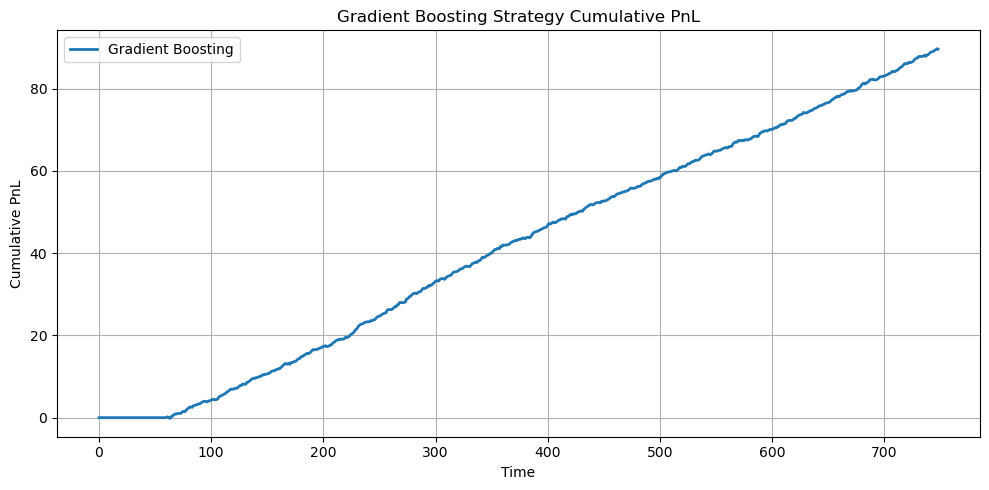

Gradient Boosting: (89.6483135852508, 0.11969067234345898, 0.14304752003282303, 13.282512826601128, 0.3490883702513443)


In [4]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load and transpose price data
data = np.loadtxt("prices.txt", dtype=float).T
n_assets, n_obs = data.shape

# Compute log returns and correlation matrix
returns = np.diff(np.log(data), axis=1)
cor_matrix = np.corrcoef(returns)

def top_corr(cor_mat, top_n=10):
    n = cor_mat.shape[0]
    pairs = []
    for i in range(n):
        for j in range(i + 1, n):
            pairs.append(((i, j), cor_mat[i, j]))
    pairs = sorted(pairs, key=lambda x: abs(x[1]), reverse=True)
    return pairs[:top_n]

top_pairs = top_corr(cor_matrix, top_n=10)
pair_indices = [pair for pair, _ in top_pairs]
min_len = min([len(data[i]) for i, j in pair_indices])

def compute_spread_zscore(p1, p2):
    beta = np.polyfit(p1, p2, 1)[0]
    spread = p2 - beta * p1
    z = (spread - np.mean(spread)) / np.std(spread)
    return spread, z, beta

def evaluate(pnl):
    cum_pnl = np.cumsum(pnl)
    avg_daily_return = pnl.mean()
    volatility = pnl.std()
    sharpe_ratio = avg_daily_return / volatility * np.sqrt(252) if volatility else 0
    max_drawdown = (np.maximum.accumulate(cum_pnl) - cum_pnl).max()
    return cum_pnl[-1], avg_daily_return, volatility, sharpe_ratio, max_drawdown

def generate_features_labels(p1, p2, window=60, z_window=20):
    spread, z, beta = compute_spread_zscore(p1, p2)
    spread = np.array(spread)
    z = np.array(z)
    X, y = [], []
    for t in range(window, len(z) - 5):
        spread_window = spread[t - z_window:t]
        mean = np.mean(spread_window)
        std = np.std(spread_window)
        upper_band = mean + 2 * std
        lower_band = mean - 2 * std
        momentum_3 = spread[t] - spread[t - 3]
        momentum_5 = spread[t] - spread[t - 5]
        long_vol = np.std(spread[t - 40:t])
        short_vol = np.std(spread[t - 10:t])
        vol_regime = 1 if short_vol > long_vol else 0
        forward_return = spread[t + 5] - spread[t]
        label = 1 if forward_return > 0.002 else -1 if forward_return < -0.002 else 0
        features = [
            z[t], mean, std, momentum_3, momentum_5,
            spread[t] - spread[t - 1], upper_band - spread[t],
            spread[t] - lower_band, vol_regime
        ]
        X.append(features)
        y.append(label)
    return np.array(X), np.array(y), spread, z

def run_gradient_boosting(pair_indices):
    ensemble_positions = np.zeros(min_len - 1)
    for i, j in pair_indices:
        p1, p2 = data[i][:min_len], data[j][:min_len]
        X, y, spread, z = generate_features_labels(p1, p2)
        clf = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
        clf.fit(X, y)
        positions = [0] * 60
        for t in range(60, len(z) - 1):
            spread_window = spread[t - 20:t]
            mean = np.mean(spread_window)
            std = np.std(spread_window)
            upper_band = mean + 2 * std
            lower_band = mean - 2 * std
            momentum_3 = spread[t] - spread[t - 3]
            momentum_5 = spread[t] - spread[t - 5]
            long_vol = np.std(spread[t - 40:t])
            short_vol = np.std(spread[t - 10:t])
            vol_regime = 1 if short_vol > long_vol else 0
            test_feat = [
                z[t], mean, std, momentum_3, momentum_5,
                spread[t] - spread[t - 1], upper_band - spread[t],
                spread[t] - lower_band, vol_regime
            ]
            pred = clf.predict([test_feat])[0]
            positions.append(pred)
        positions = np.array(positions[:len(spread) - 1])
        spread_diff = np.diff(spread)
        pnl = positions * spread_diff
        ensemble_positions[:len(pnl)] += pnl
    return ensemble_positions / len(pair_indices)

# Run only Gradient Boosting
pnl_gb = run_gradient_boosting(pair_indices)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pnl_gb), label="Gradient Boosting", linewidth=2)
plt.title("Gradient Boosting Strategy Cumulative PnL")
plt.xlabel("Time")
plt.ylabel("Cumulative PnL")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate
print("Gradient Boosting:", evaluate(pnl_gb))


More aggressive approach

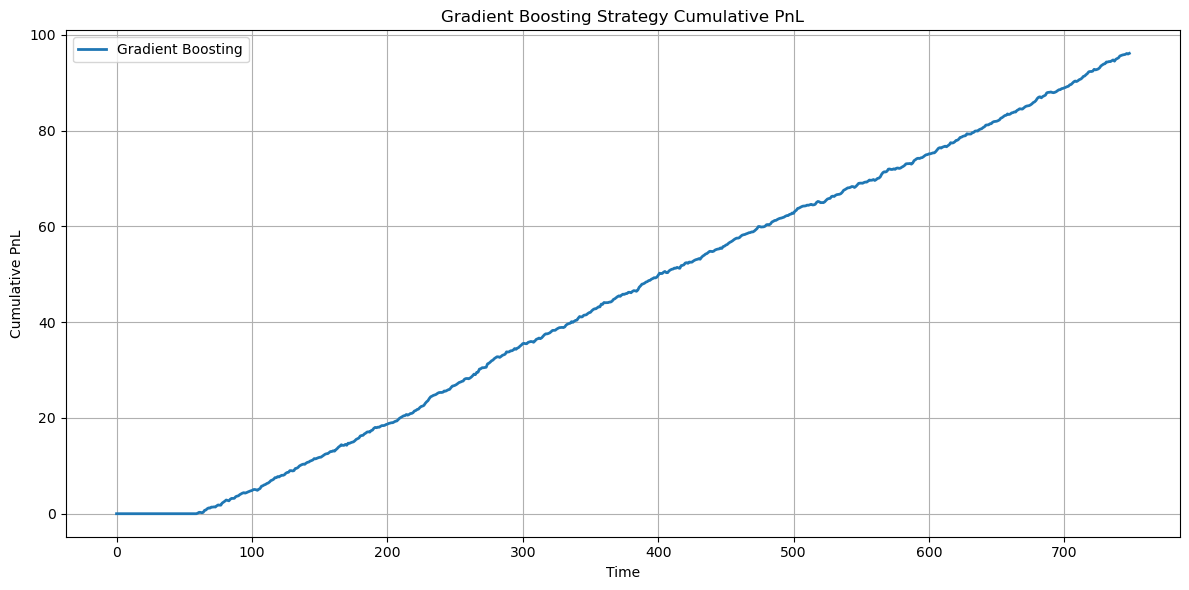

=== Gradient Boosting Strategy Performance ===
Total PnL: 96.1482
Average Daily Return: 0.128369
Volatility: 0.141900
Sharpe Ratio: 14.36
Max Drawdown: 0.2612
Final score: 0.11417883268375928


In [9]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import matplotlib.pyplot as plt

# Load and transpose price data
data = np.loadtxt("prices.txt", dtype=float).T
n_assets, n_obs = data.shape

# Compute log returns and correlation matrix
returns = np.diff(np.log(data), axis=1)
cor_matrix = np.corrcoef(returns)

def top_corr(cor_mat, top_n=10):
    n = cor_mat.shape[0]
    pairs = []
    for i in range(n):
        for j in range(i + 1, n):
            pairs.append(((i, j), cor_mat[i, j]))
    pairs = sorted(pairs, key=lambda x: abs(x[1]), reverse=True)
    return pairs[:top_n]

top_pairs = top_corr(cor_matrix, top_n=10)
pair_indices = [pair for pair, _ in top_pairs]
min_len = min([len(data[i]) for i, j in pair_indices])

def compute_spread_zscore(p1, p2):
    beta = np.polyfit(p1, p2, 1)[0]
    spread = p2 - beta * p1
    z = (spread - np.mean(spread)) / np.std(spread)
    return spread, z, beta

def generate_features_labels(p1, p2, window=60, z_window=20):
    spread, z, beta = compute_spread_zscore(p1, p2)
    spread = np.array(spread)
    z = np.array(z)
    X, y = [], []
    for t in range(window, len(z) - 5):
        spread_window = spread[t - z_window:t]
        mean = np.mean(spread_window)
        std = np.std(spread_window)
        upper_band = mean + 2 * std
        lower_band = mean - 2 * std
        momentum_3 = spread[t] - spread[t - 3]
        momentum_5 = spread[t] - spread[t - 5]
        forward_return = spread[t + 5] - spread[t]

        # Medium threshold to balance trade frequency and noise
        label = 1 if forward_return > 0.001 else -1 if forward_return < -0.001 else 0

        features = [
            z[t], mean, std, momentum_3, momentum_5,
            spread[t] - spread[t - 1], upper_band - spread[t],
            spread[t] - lower_band
        ]
        X.append(features)
        y.append(label)
    return np.array(X), np.array(y), spread, z

def run_gradient_boosting(pair_indices):
    ensemble_positions = np.zeros(min_len - 1)
    for i, j in pair_indices:
        p1, p2 = data[i][:min_len], data[j][:min_len]
        X, y, spread, z = generate_features_labels(p1, p2)

        clf = GradientBoostingClassifier(
            n_estimators=200,
            max_depth=4,
            learning_rate=0.1,
            subsample=0.8,
            random_state=42
        )
        clf.fit(X, y)

        positions = [0] * 60
        for t in range(60, len(z) - 1):
            spread_window = spread[t - 20:t]
            mean = np.mean(spread_window)
            std = np.std(spread_window)
            upper_band = mean + 2 * std
            lower_band = mean - 2 * std
            momentum_3 = spread[t] - spread[t - 3]
            momentum_5 = spread[t] - spread[t - 5]

            test_feat = [
                z[t], mean, std, momentum_3, momentum_5,
                spread[t] - spread[t - 1], upper_band - spread[t],
                spread[t] - lower_band
            ]

            pred = clf.predict([test_feat])[0]
            positions.append(pred)

        positions = np.array(positions[:len(spread) - 1])
        spread_diff = np.diff(spread)
        pnl = positions * spread_diff
        ensemble_positions[:len(pnl)] += pnl

    return ensemble_positions / len(pair_indices)

# Run the optimized model
pnl_gb = run_gradient_boosting(pair_indices)

# Plot cumulative PnL
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(pnl_gb), label="Gradient Boosting", linewidth=2)
plt.title("Gradient Boosting Strategy Cumulative PnL")
plt.xlabel("Time")
plt.ylabel("Cumulative PnL")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

cum_pnl = np.cumsum(pnl_gb)
avg_daily_return = pnl_gb.mean()
volatility = pnl_gb.std()
sharpe_ratio = avg_daily_return / volatility * np.sqrt(252) if volatility != 0 else 0
max_drawdown = (np.maximum.accumulate(cum_pnl) - cum_pnl).max()
total_pnl = cum_pnl[-1]

# Print results clearly
print("=== Gradient Boosting Strategy Performance ===")
print(f"Total PnL: {total_pnl:.4f}")
print(f"Average Daily Return: {avg_daily_return:.6f}")
print(f"Volatility: {volatility:.6f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.4f}")
print(f"Final score: {avg_daily_return-0.1*volatility}")
